In [ ]:
!pip install talos

In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from tensorflow import keras
from keras.utils import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout
from keras.layers import GlobalMaxPool1D
from keras.models import Model
import talos

#### Data loading (after preprocessing)

In [82]:
file_path = './train_preprocessed.csv'

train = pd.read_csv(file_path)

In [83]:
train.head()

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0000997932d777bf,"['explanation', 'edits', 'made', 'username', '...",0,0,0,0,0,0
1,1,000103f0d9cfb60f,"['aww', 'matches', 'background', 'colour', 'se...",0,0,0,0,0,0
2,2,000113f07ec002fd,"['hey', 'man', 'really', 'trying', 'edit', 'wa...",0,0,0,0,0,0
3,3,0001b41b1c6bb37e,"['make', 'real', 'suggestions', 'improvement',...",0,0,0,0,0,0
4,4,0001d958c54c6e35,"['sir', 'hero', 'chance', 'remember', 'page']",0,0,0,0,0,0


In [86]:
# extract word list from string

X = train['comment_text']
X = [re.findall(r'\'(.*?)\'', x) for x in X]

In [87]:
tags = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[tags].to_numpy()

#### Data preparation

##### Embedding

In [ ]:
!pip install gensim

In [ ]:
import gensim.downloader as api
glove = api.load("glove-twitter-25")

In [116]:
api.info("glove-twitter-25")

{'num_records': 1193514,
 'file_size': 109885004,
 'base_dataset': 'Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased)',
 'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/glove-twitter-25/__init__.py',
 'license': 'http://opendatacommons.org/licenses/pddl/',
 'parameters': {'dimension': 25},
 'description': 'Pre-trained vectors based on 2B tweets, 27B tokens, 1.2M vocab, uncased (https://nlp.stanford.edu/projects/glove/).',
 'preprocessing': 'Converted to w2v format with `python -m gensim.scripts.glove2word2vec -i <fname> -o glove-twitter-25.txt`.',
 'read_more': ['https://nlp.stanford.edu/projects/glove/',
  'https://nlp.stanford.edu/pubs/glove.pdf'],
 'checksum': '50db0211d7e7a2dcd362c6b774762793',
 'file_name': 'glove-twitter-25.gz',
 'parts': 1}

In [88]:
W = set()  # set of all words
for x in X:
    for w in x:
        W.add(w)

words = {w: i for i, w in enumerate(W, start=2)}

vocab = {"<PAD>": 0, "<UNK>": 1}
vocab.update(words)

In [89]:
num_words = 1193514

185764

In [90]:
X_seq= [[vocab[w] for w in x] for x in X]

In [123]:
EMBEDDING_DIM = 25

embedding_matrix = np.zeros((num_words + 1, EMBEDDING_DIM))
for word, i in vocab.items():
    if word in glove:
        embedding_vector = glove[word]
        embedding_matrix[i] = embedding_vector

##### Padding

In [124]:
maxlen = 200

X_pad=pad_sequences(X_seq, maxlen=maxlen, padding = 'post')

##### Split data into train and validation sets

In [125]:
from sklearn.model_selection import train_test_split

val_split = 0.2
X_train, X_val , y_train, y_val = train_test_split(X_pad, y, test_size=val_split)     

#### LSTM Model

##### Talos Grid Search

In [126]:
def toxic_comments_classifier(X_train, y_train, X_val, y_val, params):

  inp=Input(shape=(maxlen, ),dtype='int32')

  embedding_layer = Embedding(num_words + 1,
                           EMBEDDING_DIM,
                           weights=[embedding_matrix],
                           input_length = maxlen,
                           trainable = False)
  embedded_sequences = embedding_layer(inp)

  x = LSTM(params['lstm'], return_sequences=True)(embedded_sequences)
  
  x = GlobalMaxPool1D()(x)
  
  x = Dropout(params['dropout'])(x)
  
  x = Dense(params['dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)
  
  x = Dropout(params['dropout'])(x)
  
  preds = Dense(6, activation=params['last_activation'], kernel_initializer='glorot_uniform')(x)

  model = Model(inputs=inp, outputs=preds)

  model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])

  model_info=model.fit(X_train,y_train, epochs=params['epochs'], batch_size=params['batch_size'],  validation_data=(X_val, y_val))

  return model_info, model

In [131]:
params={
    'lstm': [10, 30, 40],
    'dense': [10, 30, 40],
    'batch_size': [32],
    'epochs':[2],
    'optimizer':['adam'],
    'activation':['relu'],
    'last_activation': ['sigmoid'],
    'dropout':[0.1, 0.2],
    'loss': ['binary_crossentropy']   
}

In [132]:
scan_results = talos.Scan(x=X_train,
               y=y_train,
               x_val=X_val,
               y_val=y_val,
               model=toxic_comments_classifier,
               params=params,
               experiment_name='lstm',
               print_params=True)

{'lstm': 10, 'dense': 10, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 245s 61ms/step - loss: 0.0959 - accuracy: 0.8869 - val_loss: 0.0656 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 229s 57ms/step - loss: 0.0678 - accuracy: 0.9937 - val_loss: 0.0625 - val_accuracy: 0.9936


  3%|▎         | 2/72 [33:50<19:44:21, 1015.17s/it]



{'lstm': 10, 'dense': 10, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 232s 58ms/step - loss: 0.1089 - accuracy: 0.8240 - val_loss: 0.0669 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 228s 57ms/step - loss: 0.0720 - accuracy: 0.9937 - val_loss: 0.0633 - val_accuracy: 0.9936


{'lstm': 10, 'dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 232s 57ms/step - loss: 0.0932 - accuracy: 0.8958 - val_loss: 0.0651 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 229s 57ms/step - loss: 0.0659 - accuracy: 0.9901 - val_loss: 0.0628 - val_accuracy: 0.9936


{'lstm': 10, 'dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 231s 57ms/step - loss: 0.0928 - accuracy: 0.8953 - val_loss: 0.0643 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 228s 57ms/step - loss: 0.0681 - accuracy: 0.9937 - val_loss: 0.0621 - val_accuracy: 0.9936


{'lstm': 10, 'dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 231s 57ms/step - loss: 0.0851 - accuracy: 0.9509 - val_loss: 0.0634 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 228s 57ms/step - loss: 0.0652 - accuracy: 0.9938 - val_loss: 0.0608 - val_accuracy: 0.9936


{'lstm': 10, 'dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 231s 57ms/step - loss: 0.0919 - accuracy: 0.9147 - val_loss: 0.0674 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 228s 57ms/step - loss: 0.0688 - accuracy: 0.9942 - val_loss: 0.0626 - val_accuracy: 0.9936


{'lstm': 30, 'dense': 10, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 243s 60ms/step - loss: 0.0882 - accuracy: 0.8242 - val_loss: 0.0638 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 241s 60ms/step - loss: 0.0633 - accuracy: 0.9855 - val_loss: 0.0586 - val_accuracy: 0.9936


{'lstm': 30, 'dense': 10, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 246s 61ms/step - loss: 0.0922 - accuracy: 0.8570 - val_loss: 0.0628 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 244s 61ms/step - loss: 0.0660 - accuracy: 0.9939 - val_loss: 0.0599 - val_accuracy: 0.9936


{'lstm': 30, 'dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 246s 61ms/step - loss: 0.0804 - accuracy: 0.9232 - val_loss: 0.0613 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 243s 61ms/step - loss: 0.0626 - accuracy: 0.9929 - val_loss: 0.0597 - val_accuracy: 0.9936


{'lstm': 30, 'dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 246s 61ms/step - loss: 0.0865 - accuracy: 0.8986 - val_loss: 0.0628 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 245s 61ms/step - loss: 0.0640 - accuracy: 0.9931 - val_loss: 0.0613 - val_accuracy: 0.9936


{'lstm': 30, 'dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 248s 61ms/step - loss: 0.0785 - accuracy: 0.9388 - val_loss: 0.0639 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 245s 61ms/step - loss: 0.0617 - accuracy: 0.9935 - val_loss: 0.0580 - val_accuracy: 0.9936


{'lstm': 30, 'dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 247s 61ms/step - loss: 0.0810 - accuracy: 0.9111 - val_loss: 0.0617 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 245s 61ms/step - loss: 0.0634 - accuracy: 0.9934 - val_loss: 0.0610 - val_accuracy: 0.9936


{'lstm': 40, 'dense': 10, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 264s 65ms/step - loss: 0.0867 - accuracy: 0.8717 - val_loss: 0.0634 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 261s 65ms/step - loss: 0.0641 - accuracy: 0.9918 - val_loss: 0.0594 - val_accuracy: 0.9936


{'lstm': 40, 'dense': 10, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 263s 65ms/step - loss: 0.0888 - accuracy: 0.8735 - val_loss: 0.0629 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 260s 65ms/step - loss: 0.0659 - accuracy: 0.9930 - val_loss: 0.0599 - val_accuracy: 0.9936


{'lstm': 40, 'dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 266s 66ms/step - loss: 0.0763 - accuracy: 0.9468 - val_loss: 0.0598 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 262s 66ms/step - loss: 0.0608 - accuracy: 0.9928 - val_loss: 0.0571 - val_accuracy: 0.9936


{'lstm': 40, 'dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 264s 65ms/step - loss: 0.0799 - accuracy: 0.9378 - val_loss: 0.0602 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 260s 65ms/step - loss: 0.0630 - accuracy: 0.9939 - val_loss: 0.0580 - val_accuracy: 0.9936


{'lstm': 40, 'dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 265s 66ms/step - loss: 0.0747 - accuracy: 0.9202 - val_loss: 0.0609 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 262s 66ms/step - loss: 0.0607 - accuracy: 0.9924 - val_loss: 0.0580 - val_accuracy: 0.9936


{'lstm': 40, 'dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 264s 66ms/step - loss: 0.0802 - accuracy: 0.9014 - val_loss: 0.0605 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 261s 65ms/step - loss: 0.0626 - accuracy: 0.9924 - val_loss: 0.0607 - val_accuracy: 0.9936



100%|██████████| 18/18 [2:28:22<00:00, 494.60s/it]


In [134]:
model_id = scan_results.data['accuracy'].astype('float').argmax()
model_id

5

#### Best Model

In [141]:
#{'lstm': 10, 'dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}

inp=Input(shape=(maxlen, ),dtype='int32')
embedding_layer = Embedding(num_words + 1,
                           EMBEDDING_DIM,
                           weights=[embedding_matrix],
                           input_length = maxlen,
                           trainable = False)
embedded_sequences = embedding_layer(inp)

In [142]:
x = LSTM(10, return_sequences=True)(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.2)(x)
x = Dense(40, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

In [143]:
model = Model(inputs=inp, outputs=preds)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [144]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 25)           4644125   
                                                                 
 lstm (LSTM)                 (None, 200, 10)           1440      
                                                                 
 global_max_pooling1d (Globa  (None, 10)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 40)                440       
                                                             

In [145]:
model_info=model.fit(X_train,y_train, epochs=2, batch_size=32,  validation_data=(X_val, y_val))

Epoch 1/2
3990/3990 [==============================] - 229s 57ms/step - loss: 0.0908 - accuracy: 0.9238 - val_loss: 0.0654 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 238s 60ms/step - loss: 0.0694 - accuracy: 0.9933 - val_loss: 0.0630 - val_accuracy: 0.9936


In [156]:
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

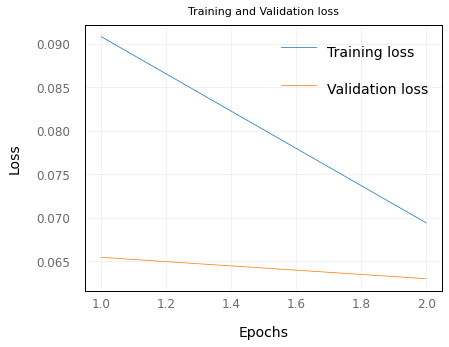

In [157]:
loss = model_info.history['loss']
val_loss = model_info.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

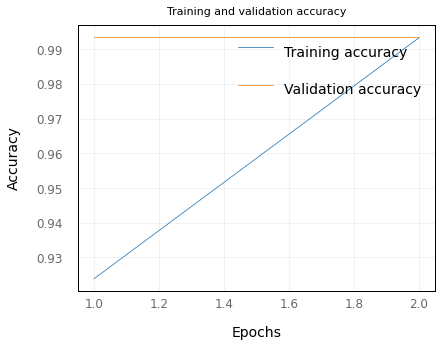

In [158]:
accuracy = model_info.history['accuracy']
val_accuracy = model_info.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()